In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import edward as ed
ed.set_seed(42)

In [4]:
def _weight_variable(name, shape):
    w = tf.get_variable(name, shape, tf.float32, tf.truncated_normal_initializer(stddev=0.1))
    tf.add_to_collection('vars',w)
    return w


def _bias_variable(name, shape):
    b = tf.get_variable(name, shape,tf.float32, tf.constant_initializer(0.1, dtype=tf.float32))
    tf.add_to_collection('vars',b)
    return b

In [5]:
def inference_network(x,y):
    x_dim = x.get_shape()[1]
    
    #layer 1 for input x
    with tf.variable_scope('x_layer1') as scope:
        weights = _weight_variable('weights',[x_dim,500])
        biases = _bias_variable('biases',[500])
        x_layer1 = tf.nn.relu(tf.matmul(x,weights) + biases)
        
    y_dim = y.get_shape()[1]
    with tf.variable_scope('y_layer1') as scope:
        weights = _weight_variable('weights',[y_dim,500])
        biases = _bias_variable('biases',[500])
        y_layer1 = tf.nn.relu(tf.matmul(y,weights) + biases)
        
    #concatenate the outputs of the first layers
    xy_combine = tf.concat([x_layer1,y_layer1],axis=1)
    
    #build the combined layer
    with tf.variable_scope('xy_layer2') as scope:
        weights = _weight_variable('weights',[1000,500])
        biases = _bias_variable('biases',[500])
        layer2 = tf.nn.relu(tf.matmul(xy_combine,weights)+biases)
    
    #output layer
    with tf.variable_scope('inference_output') as scope:
        weights = _weight_variable('weights',[500,latent_dimension*2])
        biases = _bias_variable('biases',[latent_dimension*2])
        output = tf.matmul(layer2,weights) + biases
    
    #q(z|x)
    mu = output[:,:latent_dimension]
    sigma = tf.nn.softplus(output[:,latent_dimension:])
    
    return mu,sigma

In [6]:
def generative_network(z):
    
    #layer 1 x
    with tf.variable_scope('gen_x_layer1') as scope:
        weights = _weight_variable('weights',[latent_dimension,500])
        biases = _bias_variable('biases',[500])
        x_layer1 = tf.nn.relu(tf.matmul(z,weights) + biases)
        
    #layer 1 y
    with tf.variable_scope('gen_y_layer1') as scope:
        weights = _weight_variable('weights',[latent_dimension,500])
        biases = _bias_variable('biases',[500])
        y_layer1 = tf.nn.relu(tf.matmul(z,weights) + biases)
    
    #layer 2 x
    with tf.variable_scope('gen_x_layer2') as scope:
        weights = _weight_variable('weights',[500,500])
        biases = _bias_variable('biases',[500])
        x_layer2 = tf.nn.relu(tf.matmul(x_layer1,weights) + biases)
    
    #layer 2 y
    with tf.variable_scope('gen_y_layer2') as scope:
        weights = _weight_variable('weights',[500,500])
        biases = _bias_variable('biases',[500])
        y_layer2 = tf.nn.relu(tf.matmul(y_layer1,weights) + biases)
        
        
    #gen x
    with tf.variable_scope('gen_x') as scope:
        weights = _weight_variable('weights',[500,28*14])
        biases = _bias_variable('biases',[28*14])
        x_mu = tf.nn.sigmoid(tf.matmul(x_layer2,weights) + biases)
    
    #reconstruct y
    with tf.variable_scope('gen_y') as scope:
        weights = _weight_variable('weights',[500,28*14])
        biases = _bias_variable('biases',[28*14])
        y_mu = tf.nn.sigmoid(tf.matmul(y_layer2,weights) + biases)
        
    return x_mu,y_mu

In [7]:
def VAE_loss(x_ph,x_mu,y_ph,y_mu, z_mu,z_sigma,global_step,  learning_rate_initial = 0.01,learning_decay = 0.99):
    
    #p(x|z)
    reconstruct_loss_x = -tf.reduce_sum(x_ph*tf.log(x_mu +1e-8) + \
                                    (1-x_ph)*tf.log(1-x_mu+1e-8),axis = 1)
    
    #p(y|z)
    reconstruct_loss_y = -tf.reduce_sum(y_ph*tf.log(y_mu +1e-8) + \
                                    (1-y_ph)*tf.log(1-y_mu+1e-8),axis = 1)
    
    #KL(q(z|x) || p(z))  
    latent_loss = -0.5*tf.reduce_sum(1+tf.log(tf.square(z_sigma)+1e-10)
                               - tf.square(z_mu)
                               -tf.square(z_sigma),axis=1)
    
    cost = tf.reduce_mean(reconstruct_loss_x +reconstruct_loss_y + latent_loss)
    learning_rate = tf.train.exponential_decay(learning_rate_initial,global_step,10,learning_decay)
    optimiser = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,global_step = global_step)
    return cost,optimiser

In [8]:
latent_dimension = 2
batch_size = 128
global_step = tf.Variable(0,trainable=False)

In [9]:
x_ph = tf.placeholder(tf.float32,[None, 28*14])
y_ph = tf.placeholder(tf.float32,[None,28*14])


In [10]:
z_mu,z_sigma = inference_network(x_ph,y_ph)
epsilon = tf.random_normal([batch_size,latent_dimension],0,1,dtype=tf.float32)
z = tf.add(tf.multiply(z_sigma,epsilon),z_mu)
x_mu,y_mu = generative_network(z)
cost,optimiser = VAE_loss(x_ph,x_mu,y_ph,y_mu,z_mu,z_sigma,global_step)

## Train the model

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoch = 50
for epoch in range(n_epoch):
    n_iter_per_epoch = int(1000/batch_size)
    avg_loss = 0.0
    for i in range(n_iter_per_epoch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        x_train = batch_xs[:,:28*14]
        y_train = batch_xs[:,28*14:]
        cost_val, _ = sess.run([cost,optimiser], feed_dict={x_ph: x_train, y_ph: y_train})
        avg_loss +=cost_val
    avg_loss = avg_loss /n_iter_per_epoch
    
    if epoch %10 == 0:
        print("log p(x,y) >= {:0.3f}".format(avg_loss))

log p(x,y) >= 1241.255
log p(x,y) >= 193.143
log p(x,y) >= 179.329
log p(x,y) >= 176.165
log p(x,y) >= 171.323


# See how good the reconstructions are

In [12]:
batch_xs, _ = mnist.test.next_batch(batch_size)
x_test = batch_xs[:,:28*14]
y_test = batch_xs[:,28*14:]
reconstruct_x,reconstruct_y = sess.run([x_mu,y_mu], feed_dict={x_ph: x_test, y_ph: y_test})

In [13]:
reconstruct_numbers = np.concatenate((reconstruct_x,reconstruct_y),axis = 1)

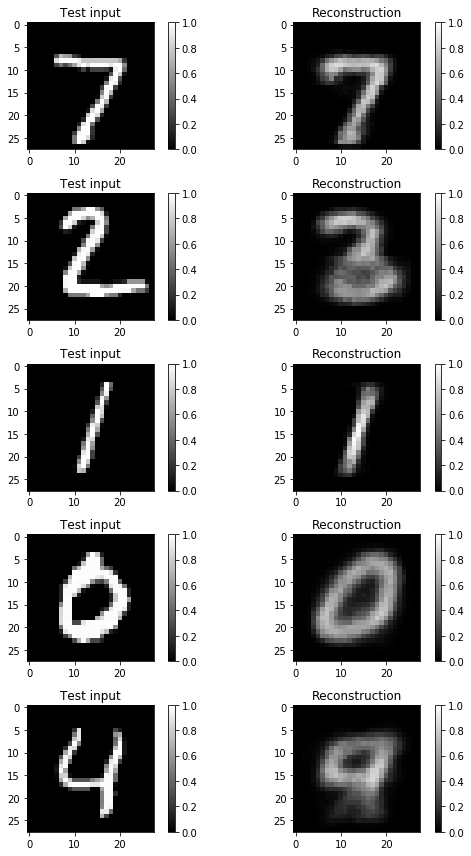

In [14]:
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(batch_xs[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconstruct_numbers[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Try to do conditional reconstruction i.e. p(y|x)

In [15]:
batch_xs, _ = mnist.test.next_batch(batch_size)
x_test = batch_xs[:,:28*14]
y_test = np.zeros((batch_size,28*14))
reconstruct_x,reconstruct_y = sess.run([x_mu,y_mu], feed_dict={x_ph: x_test, y_ph: y_test})

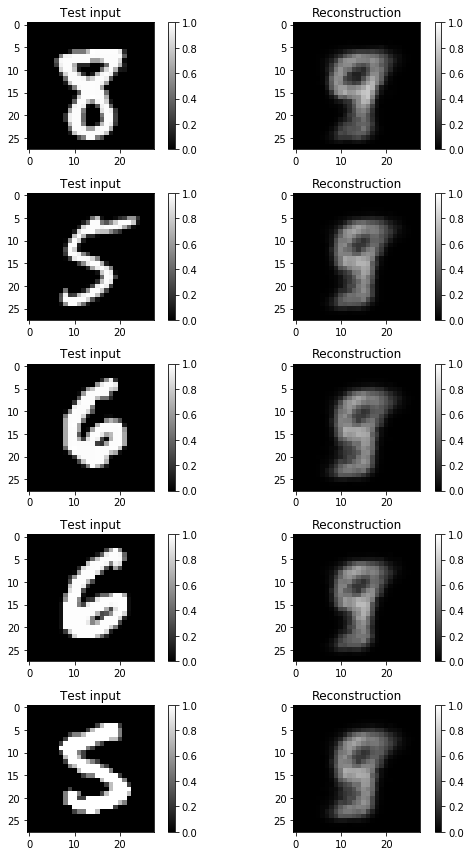

In [16]:
reconstruct_numbers = np.concatenate((reconstruct_x,reconstruct_y),axis = 1)
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(batch_xs[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconstruct_numbers[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

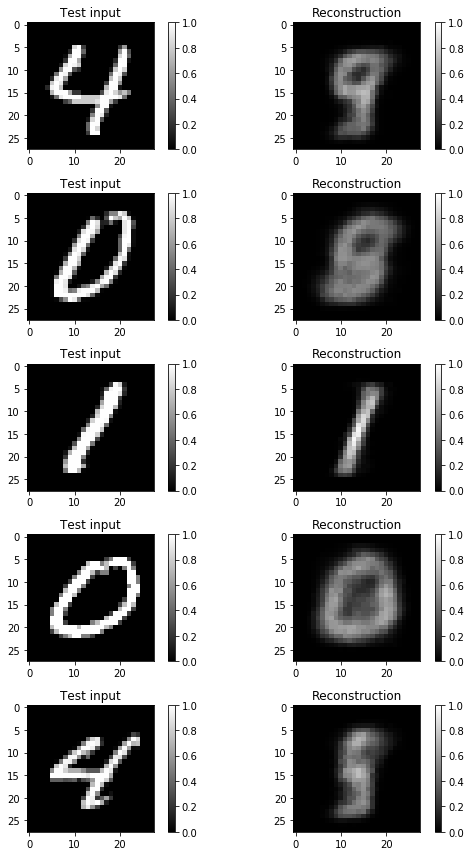

In [28]:
batch_xs, _ = mnist.test.next_batch(batch_size)
x_test = np.zeros((batch_size,28*14))
y_test = batch_xs[:,28*14:]
reconstruct_x,reconstruct_y = sess.run([x_mu,y_mu], feed_dict={x_ph: x_test, y_ph: y_test})
reconstruct_numbers = np.concatenate((reconstruct_x,reconstruct_y),axis = 1)
plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(batch_xs[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconstruct_numbers[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

# Plot the latent space

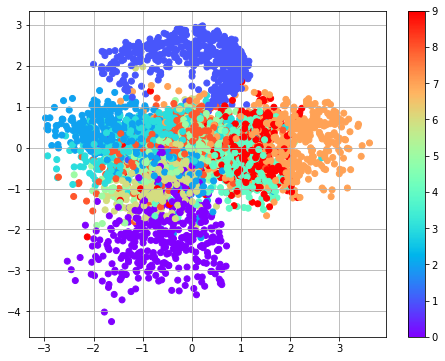

In [17]:
x_sample, y_sample = mnist.test.next_batch(5000)
x_test = x_sample[:,:14*28]
y_test = x_sample[:,14*28:]
z_mu = sess.run(z_mu,feed_dict={x_ph:x_test,y_ph:y_test})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1),cmap='rainbow')
plt.colorbar()
plt.grid()

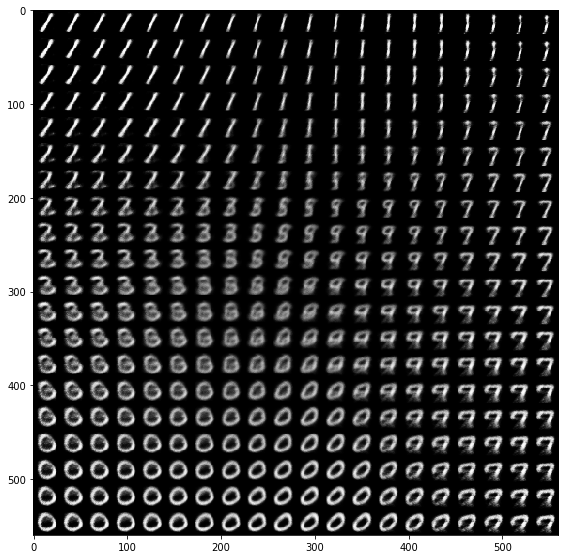

In [27]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_test = np.array([[xi, yi]]*batch_size)
        x_mean,y_mean = sess.run([x_mu,y_mu],feed_dict={z:z_test})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = np.concatenate((x_mean,y_mean),axis = 1)[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()